# Project Customer Survey

In [115]:
#from pyspark.sql import SparkSession
from pyspark import SparkContext 
import pandas as pd
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('project_abd').master("local[*]").getOrCreate()


In [116]:
df = spark.read.csv("bank_customer_survey.csv", header = True, inferSchema = True)
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: integer (nullable = true)



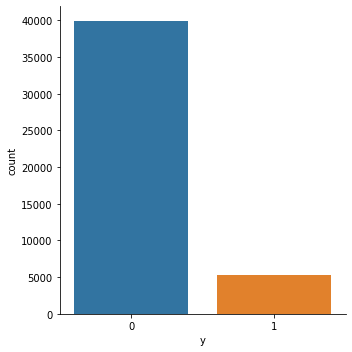

In [117]:
class_distribution = df.groupby('y').count().toPandas()
sns.catplot(x="y", y="count", kind="bar", data=class_distribution)

In [118]:
df.dtypes

[('age', 'int'),
 ('job', 'string'),
 ('marital', 'string'),
 ('education', 'string'),
 ('default', 'string'),
 ('balance', 'int'),
 ('housing', 'string'),
 ('loan', 'string'),
 ('contact', 'string'),
 ('day', 'int'),
 ('month', 'string'),
 ('duration', 'int'),
 ('campaign', 'int'),
 ('pdays', 'int'),
 ('previous', 'int'),
 ('poutcome', 'string'),
 ('y', 'int')]

In [119]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas()

,summary,age,balance,day,duration,campaign,pdays,previous,y
0,count,45211,45211,45211,45211,45211,45211,45211,45211
1,mean,40.93621021432837,1362.2720576850766,15.80641879188693,258.1630797814691,2.763840658246887,40.19782796222158,0.5803233726305546,0.11698480458295547
2,stddev,10.618762040975405,3044.7658291685257,8.322476153044594,257.5278122651706,3.098020883279192,100.12874599059828,2.303441044931218,0.32140573261566385
3,min,18,-8019,1,0,1,-1,0,0
4,max,95,102127,31,4918,63,871,275,1


In [120]:
from pandas.plotting import scatter_matrix



In [121]:
numeric_data

,age,balance,day,duration,campaign,pdays,previous,y
0,58,2143,5,261,1,-1,0,0
1,44,29,5,151,1,-1,0,0
2,33,2,5,76,1,-1,0,0
3,47,1506,5,92,1,-1,0,0
4,33,1,5,198,1,-1,0,0
...,...,...,...,...,...,...,...,...
45206,51,825,17,977,3,-1,0,1
45207,71,1729,17,456,2,-1,0,1
45208,72,5715,17,1127,5,184,3,1
45209,57,668,17,508,4,-1,0,0


In [122]:
df = df.select('age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y')
cols = df.columns
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: integer (nullable = true)



In [123]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']

stages = []

for categoricalCol in categoricalColumns:
    
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    
    stages += [stringIndexer, encoder]

In [124]:
label_stringIdx = StringIndexer(inputCol = 'y', outputCol = 'label')

stages += [label_stringIdx]

numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols

assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

stages += [assembler]

In [125]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()


root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: integer (nullable = true)



In [126]:
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 31716


Test Dataset Count: 13495


# Creating Logistic Regression Model



In [127]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)


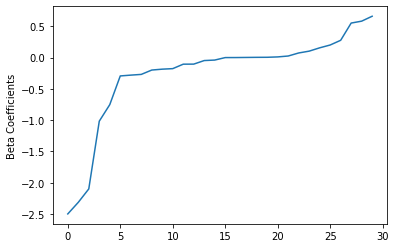

In [128]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

/Users/komlan/pythonEnv/lib/python3.9/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Training set areaUnderROC: 0.8893819685424522


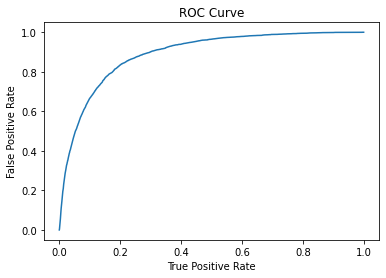

In [136]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.savefig("precision_recall.png")
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

/Users/komlan/pythonEnv/lib/python3.9/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


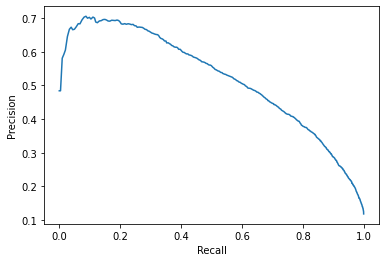

In [131]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [73]:
predictions = lrModel.transform(test)

predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----+-----+--------------------+----------+--------------------+
|age| job|label|       rawPrediction|prediction|         probability|
+---+----+-----+--------------------+----------+--------------------+
| 24|blue|  0.0|[3.70038618690010...|       0.0|[0.97588206964663...|
| 26|blue|  0.0|[3.35922810707749...|       0.0|[0.96640572569520...|
| 26|blue|  0.0|[3.13807248724923...|       0.0|[0.95843616356727...|
| 26|blue|  0.0|[0.98479177264445...|       0.0|[0.72805797338141...|
| 27|blue|  0.0|[4.62265241584983...|       0.0|[0.99026892732556...|
| 28|blue|  0.0|[3.06394670619343...|       0.0|[0.95538084098277...|
| 28|blue|  0.0|[3.15379880374952...|       0.0|[0.95905814457810...|
| 28|blue|  0.0|[3.06317159677342...|       0.0|[0.95534778772874...|
| 28|blue|  0.0|[2.47175165699889...|       0.0|[0.92213762657030...|
| 28|blue|  0.0|[2.61145448494409...|       0.0|[0.93159514245437...|
+---+----+-----+--------------------+----------+--------------------+
only showing top 10 

In [72]:
print(predictions.select("label").collect()[0])

Row(label=0.0)


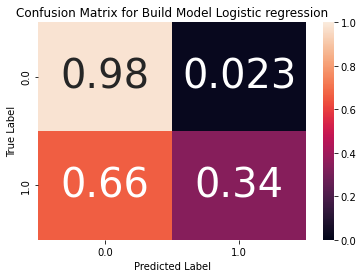

In [130]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes=None, title=None, model=None):
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0, vmax=1, annot=True, annot_kws={'size':40})
    else:
        sns.heatmap(cm, vmin=0, vmax=1)
    plt.title(title+" "+model)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

y_pred = predictions.select("prediction").collect()
y_label = predictions.select("label").collect()

cm = confusion_matrix(y_label, y_pred)

cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
classes = np.unique(y_label)
plot_confusion_matrix(cm_norm, classes, title="Confusion Matrix for Build Model", model="Logistic regression")

In [129]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8953123002168385


# Decision Tree Classifier



In [48]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions_dt = dtModel.transform(test)
predictions_dt.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----+-----+----------------+----------+--------------------+
|age| job|label|   rawPrediction|prediction|         probability|
+---+----+-----+----------------+----------+--------------------+
| 24|blue|  0.0|[25762.0,2132.0]|       0.0|[0.92356779235677...|
| 26|blue|  0.0|[25762.0,2132.0]|       0.0|[0.92356779235677...|
| 26|blue|  0.0|[25762.0,2132.0]|       0.0|[0.92356779235677...|
| 26|blue|  0.0|   [598.0,788.0]|       1.0|[0.43145743145743...|
| 27|blue|  0.0|[25762.0,2132.0]|       0.0|[0.92356779235677...|
| 28|blue|  0.0|[25762.0,2132.0]|       0.0|[0.92356779235677...|
| 28|blue|  0.0|[25762.0,2132.0]|       0.0|[0.92356779235677...|
| 28|blue|  0.0|[25762.0,2132.0]|       0.0|[0.92356779235677...|
| 28|blue|  0.0|[25762.0,2132.0]|       0.0|[0.92356779235677...|
| 28|blue|  0.0|[25762.0,2132.0]|       0.0|[0.92356779235677...|
+---+----+-----+----------------+----------+--------------------+
only showing top 10 rows



In [49]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions_dt, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.32359953259741137


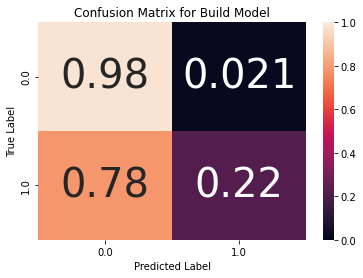

In [50]:
y_pred = predictions_dt.select("prediction").collect()
y_label = predictions_dt.select("label").collect()

cm = confusion_matrix(y_label, y_pred)

cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
classes = np.unique(y_label)
plot_confusion_matrix(cm_norm, classes, title="Confusion Matrix for Build Model")

# Random Forest Classifier



In [52]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
predictions_rf = rfModel.transform(test)
predictions_rf.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----+-----+--------------------+----------+--------------------+
|age| job|label|       rawPrediction|prediction|         probability|
+---+----+-----+--------------------+----------+--------------------+
| 24|blue|  0.0|[18.6469398644854...|       0.0|[0.93234699322427...|
| 26|blue|  0.0|[18.5656064095558...|       0.0|[0.92828032047779...|
| 26|blue|  0.0|[18.5514852181227...|       0.0|[0.92757426090613...|
| 26|blue|  0.0|[12.2148831304761...|       0.0|[0.61074415652380...|
| 27|blue|  0.0|[18.6122067428145...|       0.0|[0.93061033714072...|
| 28|blue|  0.0|[18.6604187992413...|       0.0|[0.93302093996206...|
| 28|blue|  0.0|[18.5603148918463...|       0.0|[0.92801574459231...|
| 28|blue|  0.0|[18.4875952109332...|       0.0|[0.92437976054666...|
| 28|blue|  0.0|[18.5617956703809...|       0.0|[0.92808978351904...|
| 28|blue|  0.0|[18.4875952109332...|       0.0|[0.92437976054666...|
+---+----+-----+--------------------+----------+--------------------+
only showing top 10 

In [53]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8953123002168385


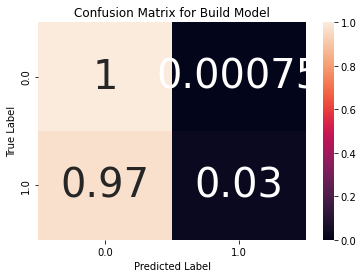

In [54]:
y_pred = predictions_rf.select("prediction").collect()
y_label = predictions_rf.select("label").collect()

cm = confusion_matrix(y_label, y_pred)

cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
classes = np.unique(y_label)
plot_confusion_matrix(cm_norm, classes, title="Confusion Matrix for Build Model")

# Gradient-Boosted Tree Classifier



In [55]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions_gb = gbtModel.transform(test)
predictions_gb.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)


+---+----+-----+--------------------+----------+--------------------+
|age| job|label|       rawPrediction|prediction|         probability|
+---+----+-----+--------------------+----------+--------------------+
| 24|blue|  0.0|[1.17441313120433...|       0.0|[0.91284088741828...|
| 26|blue|  0.0|[1.01066344014046...|       0.0|[0.88301814168673...|
| 26|blue|  0.0|[1.01066344014046...|       0.0|[0.88301814168673...|
| 26|blue|  0.0|[0.08492001100742...|       0.0|[0.54235823358291...|
| 27|blue|  0.0|[1.31814327938233...|       0.0|[0.93316072267618...|
| 28|blue|  0.0|[1.01066344014046...|       0.0|[0.88301814168673...|
| 28|blue|  0.0|[0.99476125139214...|       0.0|[0.87969261148218...|
| 28|blue|  0.0|[0.98654751460312...|       0.0|[0.87794316145541...|
| 28|blue|  0.0|[0.98507910321183...|       0.0|[0.87762810508960...|
| 28|blue|  0.0|[0.97104024755851...|       0.0|[0.87458052970339...|
+---+----+-----+--------------------+----------+--------------------+
only showing top 10 

22/02/27 22:47:09 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/02/27 22:47:09 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


In [114]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8979577336929039


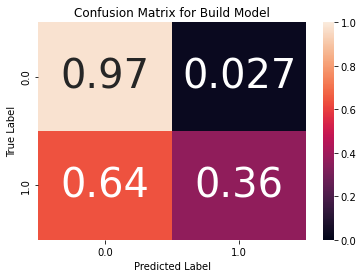

In [56]:
y_pred = predictions_gb.select("prediction").collect()
y_label = predictions_gb.select("label").collect()

cm = confusion_matrix(y_label, y_pred)

cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
classes = np.unique(y_label)
plot_confusion_matrix(cm_norm, classes, title="Confusion Matrix for Build Model")

# Linear Support Vector Machine


In [57]:
from pyspark.ml.classification import LinearSVC
lsvc = LinearSVC(maxIter=10, regParam=0.1)

# Fit the model
lsvcModel = lsvc.fit(train)

# Print the coefficients and intercept for linearsSVC
print("Coefficients: " + str(lsvcModel.coefficients))
print("Intercept: " + str(lsvcModel.intercept))

Coefficients: [-0.012602874801917192,0.0020956546410919982,0.005201289329219625,0.01971942247361287,0.01869444722545187,0.022118035826054233,-0.00017380305191347747,-0.015915744726216735,0.003216934942619754,-0.023033663424606575,0.05775986133171181,-0.005383102983763748,0.002859362972033549,-0.01772557394538835,0.008138858947710988,-0.01550108158315846,0.042387527759952824,-0.050173097908114424,0.04259226567114565,-0.0,-0.12978842608454233,-0.3170658222298964,-0.3602447994762481,-0.3517795715288839,0.0006346803279004707,9.829938476057113e-07,0.00033297561025221573,-0.00909429409389848,0.00027905713615209945,6.59452675236113e-05]
Intercept: -0.8787616405017249


In [59]:
predictions_svm = lsvcModel.transform(test)
predictions_svm.select('age', 'job', 'label', 'rawPrediction', 'prediction').show(10)


+---+----+-----+--------------------+----------+
|age| job|label|       rawPrediction|prediction|
+---+----+-----+--------------------+----------+
| 24|blue|  0.0|[1.16112179602391...|       0.0|
| 26|blue|  0.0|[1.13281973112686...|       0.0|
| 26|blue|  0.0|[1.11377029963265...|       0.0|
| 26|blue|  0.0|[0.93387278993171...|       0.0|
| 27|blue|  0.0|[1.23932578958779...|       0.0|
| 28|blue|  0.0|[1.10632262937145...|       0.0|
| 28|blue|  0.0|[1.11366649580269...|       0.0|
| 28|blue|  0.0|[1.10645205645943...|       0.0|
| 28|blue|  0.0|[1.05743237916663...|       0.0|
| 28|blue|  0.0|[1.06890858906571...|       0.0|
+---+----+-----+--------------------+----------+
only showing top 10 rows



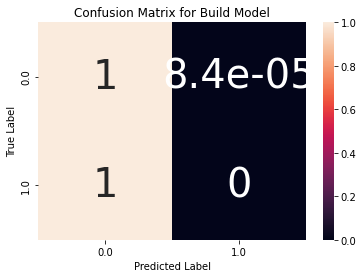

In [60]:
y_pred = predictions_svm.select("prediction").collect()
y_label = predictions_svm.select("label").collect()

cm = confusion_matrix(y_label, y_pred)

cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
classes = np.unique(y_label)
plot_confusion_matrix(cm_norm, classes, title="Confusion Matrix for Build Model")